# Project

## 1. Title: 
Cyberbullying Tweet Recognition

## 2. Brief on the project:
With rise of social media coupled with the Covid-19 pandemic, cyberbullying has reached all time highs. We can combat this by creating
models to automatically flag potentially harmful tweets as well as break down the patterns of hatred.

## 3. About the dataset:
As social media usage becomes increasingly prevalent in every age group, a vast majority of citizens rely on this essential medium for day-today communication. Social media’s ubiquity means that cyberbullying can effectively impact anyone at any time or anywhere, and the relative
anonymity of the internet makes such personal attacks more difficult to stop than traditional bullying.

On April 15th, 2020, UNICEF issued a warning in response to the increased risk of cyberbullying during the COVID-19 pandemic due to
widespread school closures, increased screen time, and decreased face-to-face social interaction. The statistics of cyberbullying are outright
alarming: 36.5% of middle and high school students have felt cyberbullied and 87% have observed cyberbullying, with effects ranging from
decreased academic performance to depression to suicidal thoughts.


## 4. Variables:
In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:
    
    a. Age
    b. Ethinicity
    c. Gender
    d. Religion
    e. Other type of cyberbullying
    f. Not cyberbullying


## 5. Objective:
The objective of this project is to create a model that can automatically flag potentially harmful tweets as well as break down the patterns of
hatred.

## 6. Individual Details:
Name: Vidit Kumar Pal, Email: vidit.20.pal@gmail.com, Contact: +91-7985431988

### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle

In [2]:
data=pd.read_csv('D:\Data Science\iit guwahati\course\projects made\cyberbullying tweets\cyberbullying_tweets.csv')

In [3]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
data.tail()

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [7]:
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [8]:
data=data.rename(columns={'tweet_text':'text','cyberbullying_type':'sentiment'})

In [9]:
data.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [10]:
data['sentiment_encoded']=data['sentiment'].replace({'religion':1,'age':2,'ethnicity':3,'gender':4,'other_cyberbullying':5,'not_cyberbullying':6})

In [11]:
data.head()

,text,sentiment,sentiment_encoded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6


In [12]:
stop_words=set(stopwords.words('english'))

## Preprocessing of Text

### Function to Remove Emojis

In [13]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

### Function to Convert text to lowercase,remove (/r,/n characters), URLs, non-utf characters, Numbers, punctutations, stopwords

In [14]:
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

### Function to remove contractions

In [15]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

### Function to Clean Hashtags

In [16]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

### Function to FIlter Special Characters such as $, &

In [17]:
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

### Function to remove multiple sequence spaces

In [18]:
def remove_mult_spaces(text):
    return re.sub("\s\s+"," ",text)

### Function to apply stemming to words

In [19]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

### Function to apply lemmatization to words

In [20]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])


### Function to Preprocess the text by applying all above functions

In [21]:
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [22]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Vidit\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
data['cleaned_text']=data['text'].apply(preprocess)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...


### Cleaned text added

### Dealing with Duplicates

In [24]:
data["cleaned_text"].duplicated().sum()

3041

In [25]:
data.drop_duplicates("cleaned_text", inplace=True)

### Duplicates removed

### Tokenization

In [26]:
data['tweet_list'] = data['cleaned_text'].apply(word_tokenize)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."


### Checking length of various tweet texts

In [27]:
text_len = []
for text in data.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
data['text_len'] = text_len

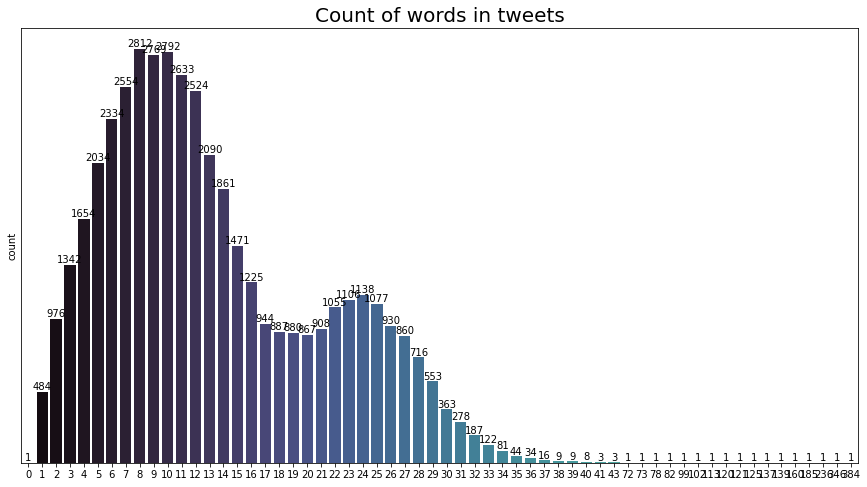

In [28]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=data, palette='mako')
plt.title('Count of words in tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### Removing text without words

In [29]:
data = data[data['text_len']!=0]

In [30]:
data.shape

(44650, 6)

### Splitting data based on sentiment for Data Exploration

In [31]:
not_cyberbullying_type = data[data['sentiment']=='not_cyberbullying']
gender_type = data[data['sentiment']=='gender']
religion_type = data[data['sentiment']=='religion']
other_cyberbullying_type = data[data['sentiment']=='other_cyberbullying']
age_type = data[data['sentiment']=='age']
ethnicity_type = data[data['sentiment']=='ethnicity']

### EDA Part

### Gender Based Cyberbullying

In [32]:
gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words','Count']
top20_gender.style.background_gradient(cmap='Greens')

,Top Words,Count
0,joke,5179
1,rape,4070
2,gay,3852
3,call,1401
4,make,1283
5,rt,1221
6,woman,1182
7,bitch,1146
8,femal,1108
9,peopl,988


Text(0.5, 1.0, 'Top 20 words in Gender Cyberbullying')

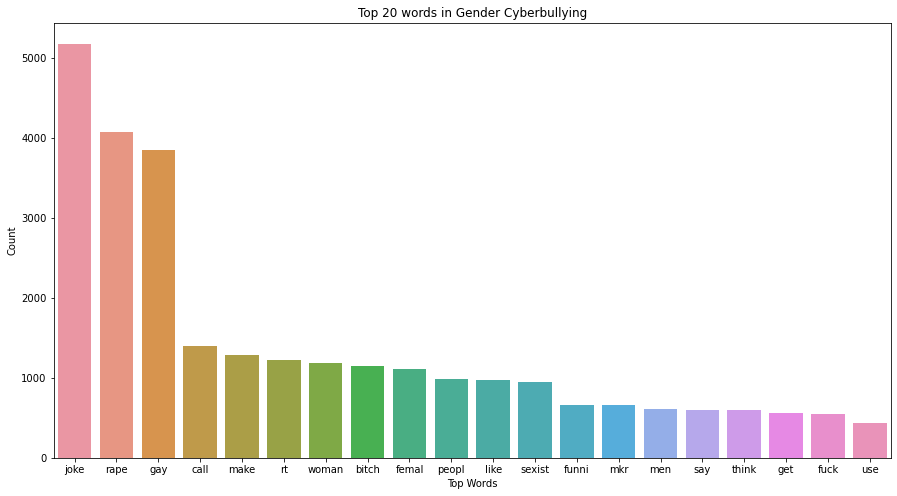

In [33]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender, y="Count", x="Top Words")
plt.title("Top 20 words in Gender Cyberbullying")

### Region Based Cyberbullying

In [34]:
religion = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))
top20_religion.columns = ['Top Words','Count']
top20_religion.style.background_gradient(cmap='Greens')

,Top Words,Count
0,muslim,4618
1,idiot,3075
2,islam,2440
3,christian,2132
4,u,1922
5,terrorist,1378
6,right,1289
7,like,1276
8,support,1251
9,woman,1247


Text(0.5, 1.0, 'Top 20 words in Religion Cyberbullying')

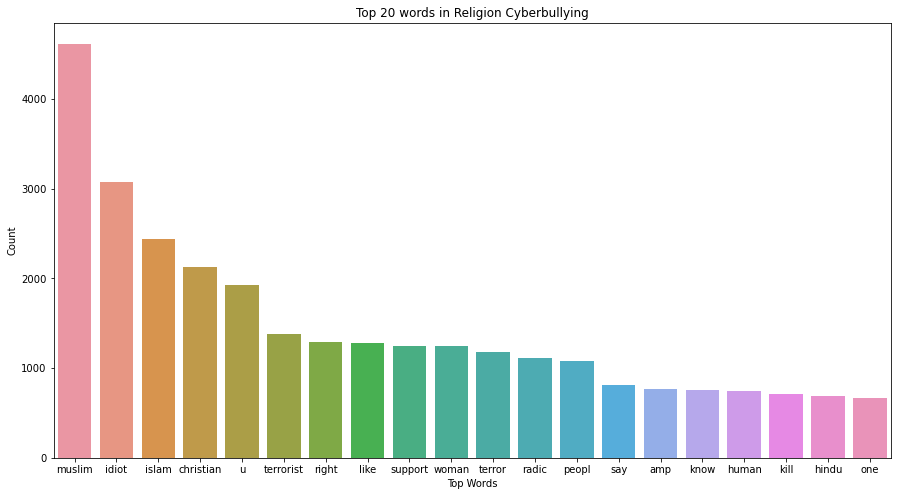

In [35]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion, y="Count", x="Top Words")
plt.title("Top 20 words in Religion Cyberbullying")

### Age based Cyberbullying

In [36]:
age = Counter([item for sublist in age_type['tweet_list'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))
top20_age.columns = ['Top Words','Count']
top20_age.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,8899
1,school,8426
2,high,4861
3,girl,4616
4,like,2076
5,get,1051
6,one,1044
7,peopl,934
8,got,842
9,kid,809


Text(0.5, 1.0, 'Top 20 words in Age Cyberbullying')

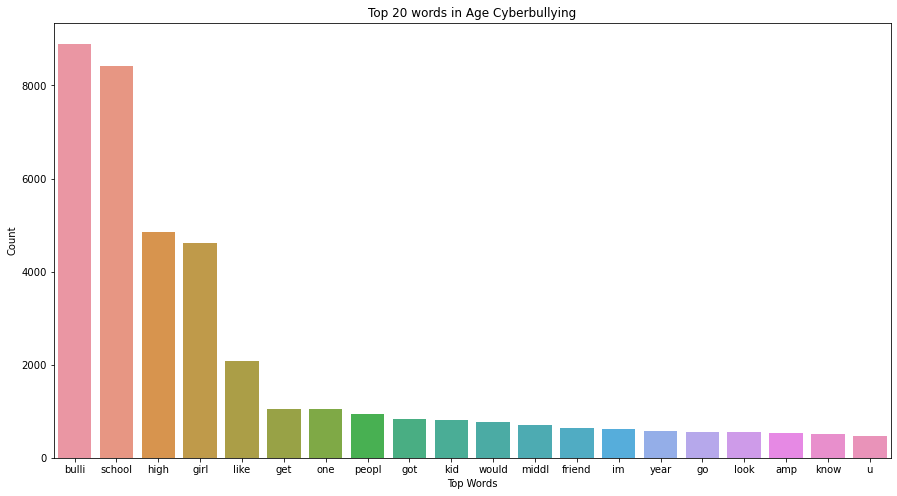

In [37]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_age, y="Count", x="Top Words")
plt.title("Top 20 words in Age Cyberbullying")

### Ethinicity based Cyberbullying

In [38]:
ethnicity = Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words','Count']
top20_ethnicity.style.background_gradient(cmap='Greens')

,Top Words,Count
0,fuck,5892
1,nigger,5456
2,dumb,5003
3,as,2241
4,black,2134
5,u,2107
6,white,1557
7,call,1381
8,peopl,1182
9,rt,1166


Text(0.5, 1.0, 'Top 20 words in Ethnicity Cyberbullying')

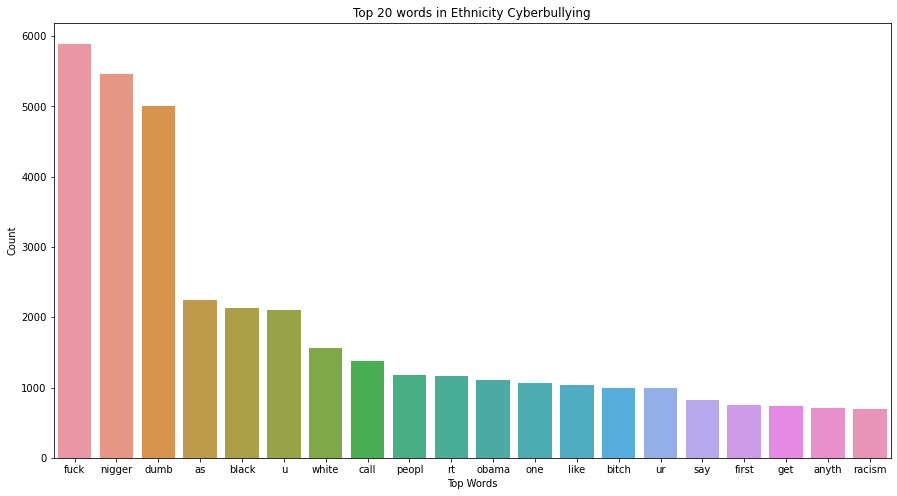

In [39]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity, y="Count", x="Top Words")
plt.title("Top 20 words in Ethnicity Cyberbullying")

### Other types of Cyberbullying

In [40]:
other_cyberbullying = Counter([item for sublist in other_cyberbullying_type['tweet_list'] for item in sublist])
top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
top20_other_cyberbullying.columns = ['Top Words','Count']
top20_other_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,882
1,rt,727
2,fuck,509
3,like,424
4,get,393
5,peopl,353
6,go,277
7,idiot,261
8,know,241
9,think,237


Text(0.5, 1.0, 'Top 20 words in Other Cyberbullying')

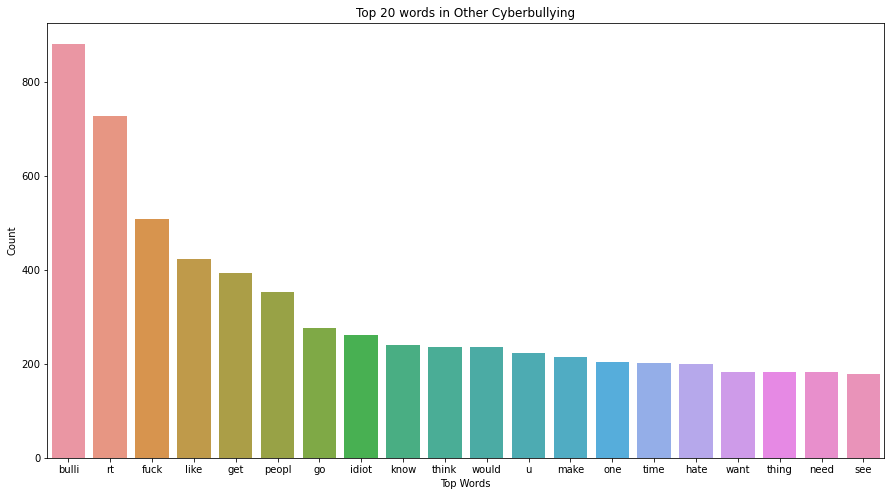

In [41]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_other_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Other Cyberbullying")

### Tweets without Cyberbullying

In [42]:
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words','Count']
top20_not_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,mkr,1674
1,bulli,1102
2,rt,785
3,like,424
4,get,423
5,go,394
6,school,374
7,kat,286
8,would,286
9,peopl,272


Text(0.5, 1.0, 'Top 20 words in Not Cyberbullying')

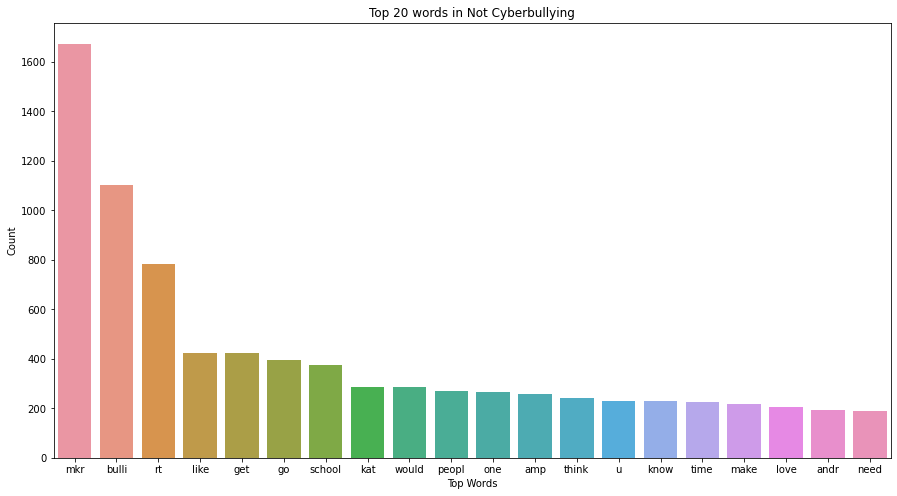

In [43]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Not Cyberbullying")

In [44]:
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like...",8


In [45]:
sentiments = ["religion", "age", "ethnicity", "gender", "other_cyberbullying","not_cyberbullying"]


### Splitting Data into Train and Test Sets

In [46]:
X,Y = data['cleaned_text'],data['sentiment_encoded']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(31255,) (31255,) (13395,) (13395,)


### tf-idf Vectorization

In [48]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(31255, 29111)
(13395, 29111)


### Trying Different ML Models

### Logistic Regression

In [49]:
lr=LogisticRegression()

In [50]:
lr_cv_score=cross_val_score(lr,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

In [51]:
mean_lr_cv = np.mean(lr_cv_score)
mean_lr_cv

0.8228272280708214

### Support Vector Classsifier

In [52]:
lin_svc = LinearSVC()

In [53]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.8220066371295554

### Naive Bayes Classifier

In [54]:
multiNB = MultinomialNB()

In [55]:
multiNB_cv_score = cross_val_score(multiNB,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score)
mean_multiNB_cv

0.6708019945279682

### Decision Tree Classifier

In [56]:
dtree = DecisionTreeClassifier()

In [57]:
dtree_cv_score = cross_val_score(dtree,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_dtree_cv = np.mean(dtree_cv_score)
mean_dtree_cv

0.8091481653456206

### Random Forest Classifier

In [58]:
rand_forest = RandomForestClassifier()

In [59]:
rand_forest_cv_score = cross_val_score(rand_forest,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

In [60]:
mean_rand_forest_cv = np.mean(rand_forest_cv_score)
mean_rand_forest_cv

0.8296975265017291

### Adaboost Classifier

In [61]:
adab=AdaBoostClassifier()

In [62]:
adab_cv_score = cross_val_score(adab,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_adab_cv = np.mean(adab_cv_score)
mean_adab_cv

0.760078727868178

#### By trying different models we can see logistic regression, svm and random forest classifier performed similarly, so among these we will go with svm model as it is more generalised and light.


#### Fine Tuning SVC

In [63]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
'loss':['hinge','squared_hinge'],
'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [64]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [65]:
grid_search.best_score_

0.8244012024546198

### Model Evaluation

In [66]:
lin_svc.fit(X_train_tf,y_train)
y_pred = lin_svc.predict(X_test_tf)

In [67]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

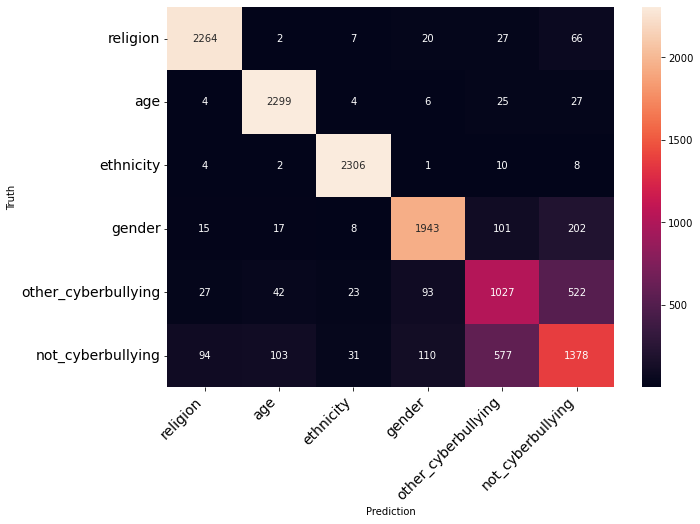

In [68]:
cm = confusion_matrix(y_test,y_pred)
print_confusion_matrix(cm,sentiments)

In [69]:
print('Classification Report:\n',classification_report(y_test, y_pred, target_names=sentiments))

Classification Report:
                      precision    recall  f1-score   support

           religion       0.94      0.95      0.94      2386
                age       0.93      0.97      0.95      2365
          ethnicity       0.97      0.99      0.98      2331
             gender       0.89      0.85      0.87      2286
other_cyberbullying       0.58      0.59      0.59      1734
  not_cyberbullying       0.63      0.60      0.61      2293

           accuracy                           0.84     13395
          macro avg       0.82      0.83      0.82     13395
       weighted avg       0.84      0.84      0.84     13395



### Saving the model


In [70]:
pickle.dump(tf_idf, open('Cyberbullyingvectorizer.pkl', 'wb'))
pickle.dump(lin_svc, open('Cyberbullyingmodel.pkl', 'wb'))

## 7. Final Report:
### Data Analysis and Treatment:
    a. There are 47692 rows and 2 columns
    b. There are no missing values
    c. There is one target variable: 'Cyberbullying_type'
    d. It is the case of multi-classification with target variable "Cyberbullying_type" having six labels as Age, Ethnicity, Gender, Religion, Other type of cyberbullying, Not cyberbullying.
    e. The best prforming model is SVC (Support Vector Classifier) with accuracy score of 84%. 